In [1]:
import numpy as np
import pandas as pd
import scipy.signal
from scipy.stats import logistic
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.integrate import simpson
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from fdasrsf.regression import elastic_regression
from fdasrsf.utility_functions import elastic_distance
import fdasrsf as fs
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_curl = pd.read_csv('vpc_curl.csv')
df_knock = pd.read_csv('vpc_knock.csv')

In [3]:
X_df = pd.merge(df_curl, df_knock, left_on=['PID'], right_on=['PID'], how='inner',suffixes=('_curl', '_knock'))
X_df = X_df[(X_df['Cohort_curl'] == 'DMD') | (X_df['Cohort_curl'] == 'SMA')]
X_df

,pids_curl,PID,Visit #_curl,Age_curl,Forearm_Length (cm)_curl,CSA (cm^2)_curl,Normalized_CSA (cm^2/cm)_curl,Avg_Long_Echo_curl,Avg_Trans_Echo_curl,Avg_Echo_curl,...,Normalized_Dynamometry (N/cm)_knock,vpc1_knock,vpc2_knock,vpc3_knock,visits_knock,Sensor Data Date_knock,Cohort_knock,DTW_knock,LCSS_knock,DEXA Date_knock
0,1.0,1.0,1.54,10.0,19.540,3.315800,0.218206,52.0146,57.90420,54.95940,...,0.739481,-14.005069,6.536640,4.860552,2021-03-26,2021-03-26,DMD,0.105,0.985,NaN
1,2.0,2.0,1.00,12.0,24.000,7.590000,0.316250,53.4000,41.45000,47.42500,...,0.295930,21.146474,11.440316,20.812938,2021-02-11,2021-02-11,DMD,0.1708,0.972,NaN
2,3.0,3.0,1.44,15.0,22.720,1.962800,0.086432,37.7864,46.98880,42.38760,...,0.623269,-7.002437,-12.439710,3.499236,2021-07-20,2021-07-20,SMA,0.1415,0.9762,NaN
3,5.0,5.0,1.00,28.0,24.000,8.150000,0.339583,33.2000,38.23000,35.71500,...,NaN,-16.298848,0.934483,4.723615,2021-03-11,2021-03-11,DMD,0.2767,0.972,NaN
5,10.0,10.0,1.00,2.0,14.000,2.060000,0.147143,35.0300,33.51000,34.27000,...,NaN,-30.536468,0.683415,5.390314,2021-03-24,2021-03-24,SMA,0.3067,0.897,NaN
6,11.0,11.0,1.46,6.0,18.000,2.428600,0.134922,36.8764,35.19140,36.03390,...,NaN,-11.653281,-2.799379,-5.362087,2021-03-24,2021-03-24,DMD,0.2697,0.934,NaN
7,12.0,12.0,1.57,33.0,22.355,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.364637,1.271983,-5.237292,2021-10-15,2021-10-15,DMD,0.2184,0.9423,NaN
8,14.0,14.0,1.00,15.0,23.000,2.401287,0.104404,44.2000,50.90574,47.55287,...,0.878040,-2.790194,-0.157573,-3.683915,2021-04-28,2021-04-28,DMD,0.1553,0.967,2021-04-28
9,15.0,15.0,1.00,7.0,19.000,3.120000,0.164211,51.6500,44.57000,48.11000,...,0.333851,-8.290478,1.902755,5.067496,2021-05-13,2021-05-13,SMA,0.2123,0.955,NaN
10,16.0,16.0,1.00,7.0,18.000,2.770000,0.153889,36.2700,22.91000,29.59000,...,1.532165,4.496469,-15.642054,13.593552,2021-05-13,2021-05-13,DMD,0.2135,0.946,NaN


In [4]:
X_df = X_df.select_dtypes(include='number')
X_df = X_df.fillna(X_df.median())

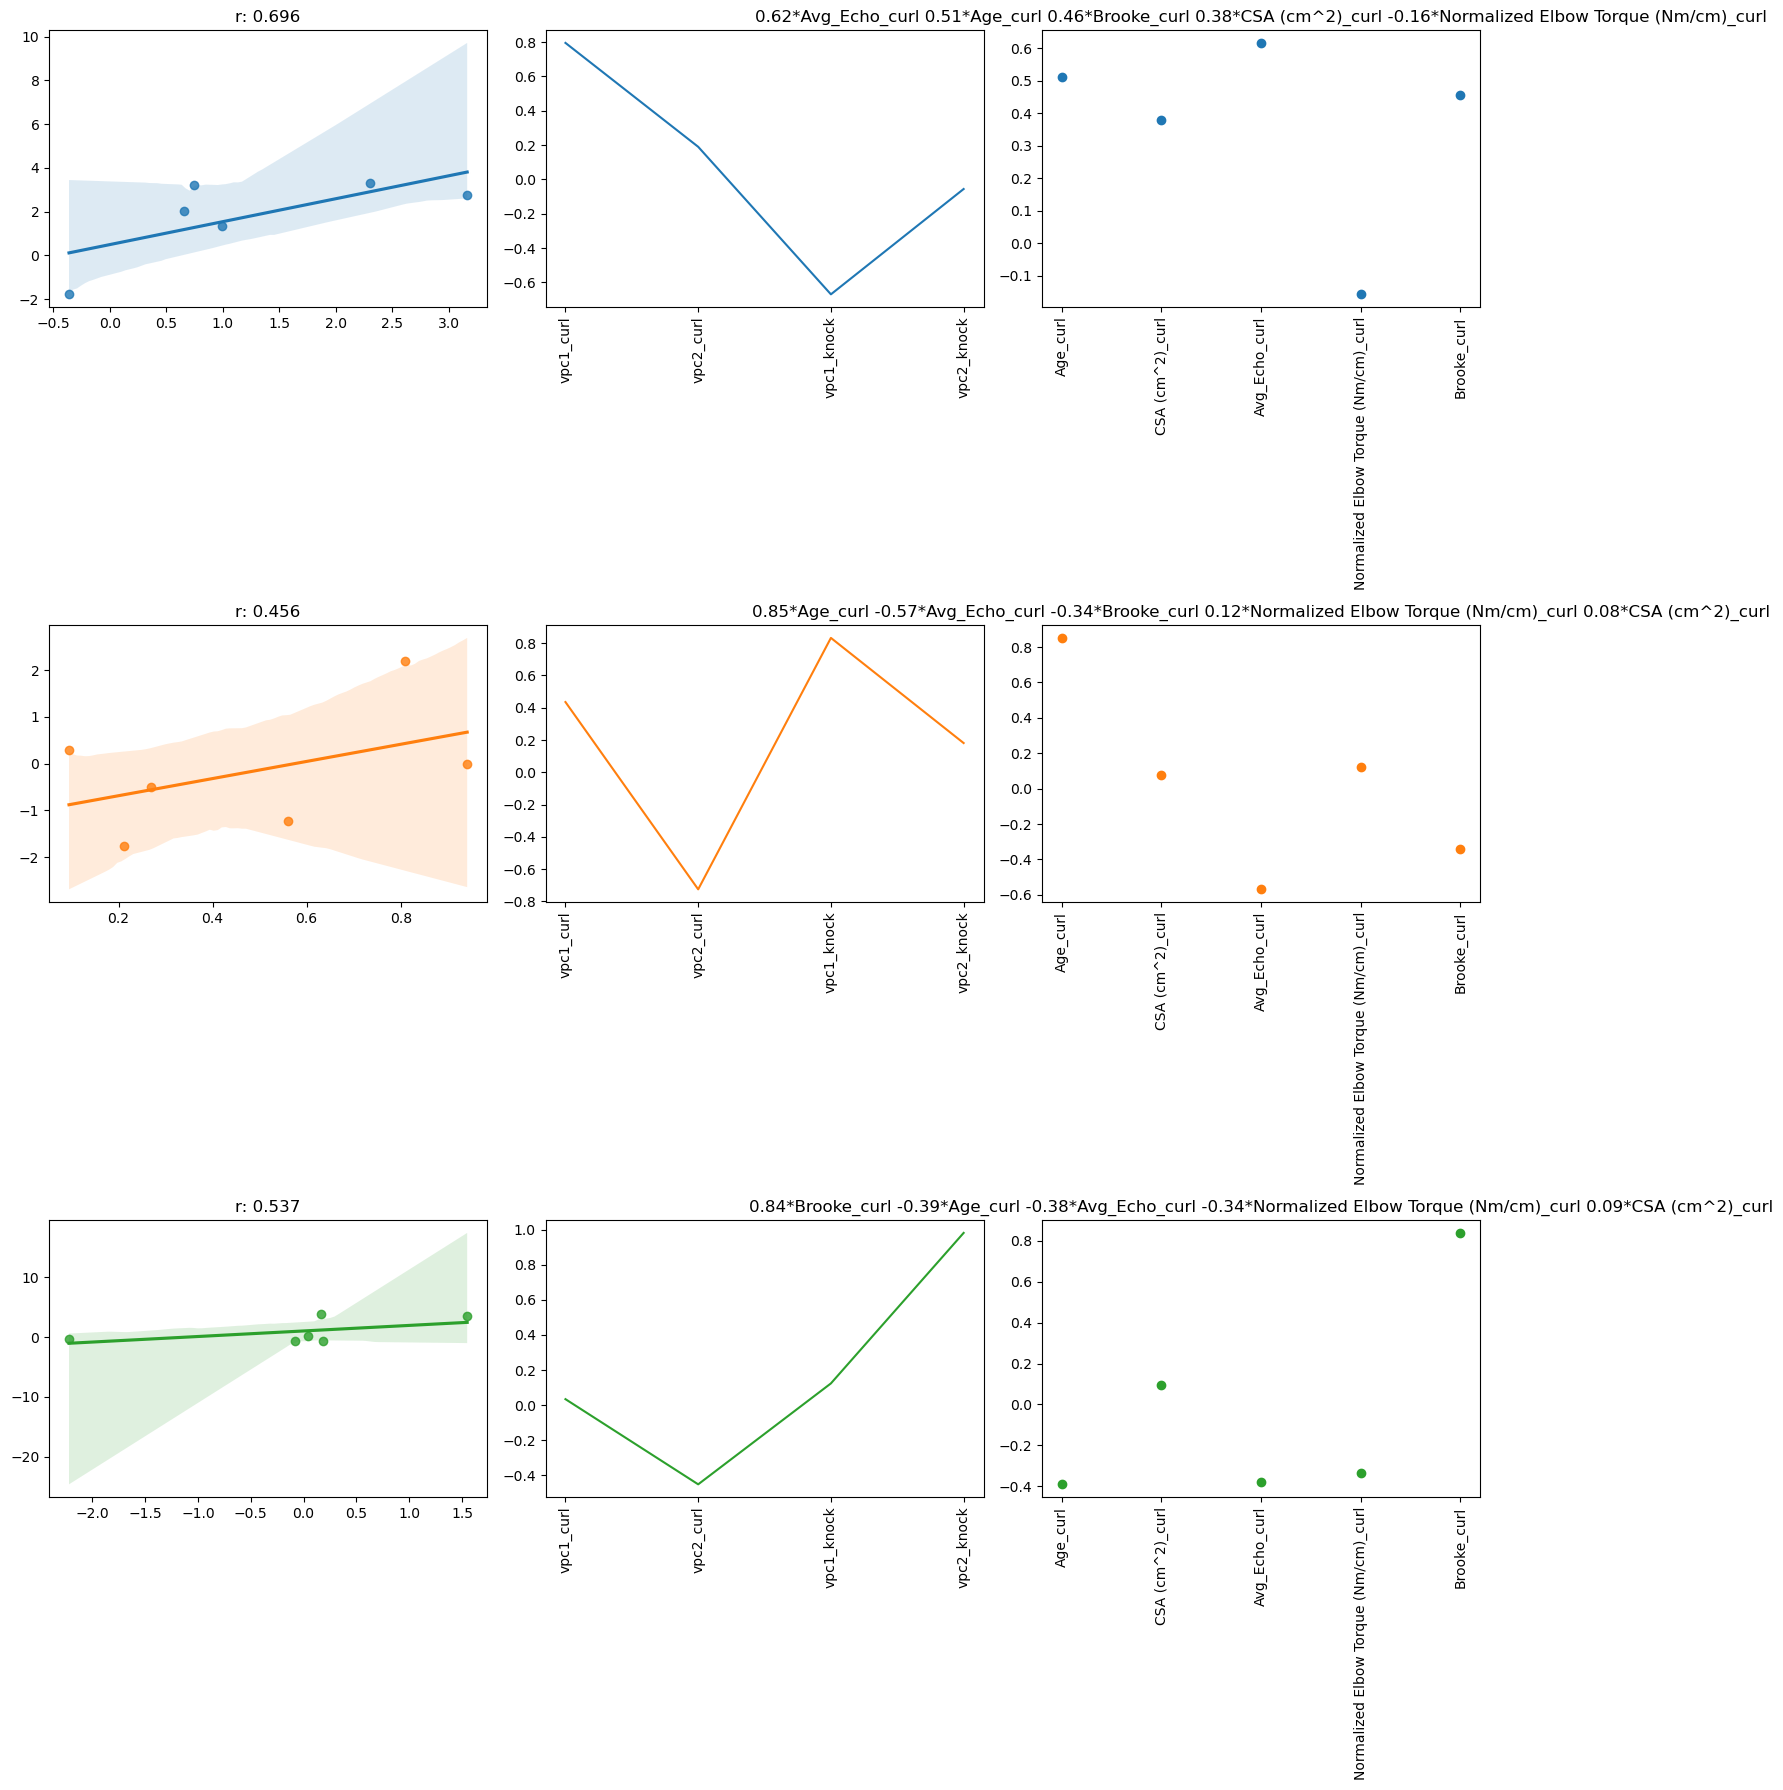

In [5]:
# from sklearn.cross_decomposition import CCA
from sklearn.cross_decomposition import PLSCanonical

# X_cols = ['vpc1_curl','vpc2_curl','vpc3_curl','vpc1_knock','vpc2_knock','vpc3_knock']

X_cols = ['vpc1_curl','vpc2_curl','vpc1_knock','vpc2_knock']
Y_cols = ['Age_curl','CSA (cm^2)_curl', 'Avg_Echo_curl','Normalized Elbow Torque (Nm/cm)_curl','Brooke_curl',]

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X_df, test_size=0.3, shuffle=True)


x_tr = X_train[X_cols]
y_tr = X_train[Y_cols]

x_tst = X_test[X_cols]
y_tst = X_test[Y_cols]

#X = X + 1000*np.random.normal(size=X.shape)
# y_tr.columns

# from sklearn.cross_decomposition import CCA
# #X = [[0., 0., 1.], [1.,0.,0.], [2.,2M.,2.], [3.,5.,4.]]
# #>>> Y = [[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]]
# cca = CCA(n_components=1)
# cca.fit(X, Y)
# #CCA(n_components=1)
# #>>> X_c, Y_c = cca.transform(X, Y)

rank = 3
plsca = PLSCanonical(n_components=rank)
# plsca = CCA(n_components=rank)
plsca.fit(x_tr, y_tr)
X_train_r, Y_train_r = plsca.transform(x_tr, y_tr)
X_test_r, Y_test_r = plsca.transform(x_tst, y_tst)

fig, axs = plt.subplots(rank, 3, figsize=(5*rank, 6*3))

colors = ['tab:blue', 'tab:orange', 'tab:green']

corrs = []

for r in range(rank):
    
    x = X_test_r[:,r]
    y = Y_test_r[:,r]
    
    rho = round(np.corrcoef(x, y)[0,1], 3)
    
    corrs.append(rho)

    axs[r,0].set_title("r: {}".format(rho))
    #axs[r,0].scatter(x, y)
    
    sns.regplot(x=x, y=y, ax=axs[r,0], color=colors[r])
    
    idxs = np.argsort(np.abs(plsca.y_loadings_[:,r]))[-5:][::-1]
    titles = y_tst.columns[idxs]
    coefs = plsca.y_loadings_[:,r][idxs]

    plot_title = ' '.join([str(round(c, 2))+'*'+str(t) for c, t in zip(coefs, titles)])
    
    
    #axs[r,1].set_title('physiology pattern: {}'.format(r))
    axs[r,1].plot(plsca.x_loadings_[:,r], c=colors[r])
    
    axs[r,2].scatter(range(y_tr.shape[1]),plsca.y_loadings_[:,r], c=colors[r])
    axs[r, 2].set_title(plot_title)
    
    axs[r,1].set_xticks(range(x_tr.shape[1]))
    axs[r,1].set_xticklabels(x_tr.columns, rotation=90)
    axs[r,2].set_xticks(range(y_tr.shape[1])) 
    axs[r,2].set_xticklabels(y_tr.columns, rotation=90)

    
plt.tight_layout()
#plt.savefig('CCA_rank_{}.png'.format(r), dpi=300, bbox_inches='tight')

## Storing Corrs and PLS list

In [6]:
from scipy import stats
from sklearn.cross_decomposition import PLSCanonical

pls_list = []
trials = 10000
corrs = np.zeros((trials, rank))


for i in tqdm(range(trials)):

    X_train, X_test = train_test_split(X_df, test_size=0.3, shuffle=True)

    x_tr = X_train[X_cols]
    y_tr = X_train[Y_cols]

    x_tst = X_test[X_cols]
    y_tst = X_test[Y_cols]


    #rank = 3

    # plsca = CCA(n_components=rank)
    plsca = PLSCanonical(n_components=rank)
    plsca.fit(x_tr, y_tr)
    pls_list.append(plsca)
    
    X_train_r, Y_train_r = plsca.transform(x_tr, y_tr)
    X_test_r, Y_test_r = plsca.transform(x_tst, y_tst)

    for r in range(rank):

        x = X_test_r[:,r]
        y = Y_test_r[:,r]
        
        rho, _ = stats.pearsonr(x, y)
        rho = round(rho, 3)
        
        corrs[i,r] = rho

  0%|          | 0/10000 [00:00<?, ?it/s]

## Using corrs (trial x rank), pls_list (trial) to generate necessary variables

In [7]:
rho_df = pd.DataFrame(corrs.flatten(), columns=['rho'])
rho_df['rank'] = list(range(rank))*trials

X_weights = []
Y_weights = []

for i, plsca in enumerate(pls_list):
    for r in range(rank):

        r1 = list(plsca.x_loadings_[:,r])
        r1.append(r)
        
        r2 = list(plsca.y_loadings_[:,r])
        r2.append(r)

        X_weights.append(r1)
        Y_weights.append(r2)
        
xweights_df = pd.DataFrame(X_weights)
yweights_df = pd.DataFrame(Y_weights)

xweights_df.columns = [*X_cols,'rank']
yweights_df.columns = [*Y_cols,'rank']

cca_df = pd.concat([rho_df, xweights_df.drop('rank',axis=1), yweights_df.drop('rank',axis=1)],axis=1)
cca_df.groupby('rank').agg('median')


cca_df.columns = ['r','rank','VPC1 Curl', 'VPC2 Curl','VPC1 Knock','VPC2 Knock','Age',
                  'CSA (cm^2)', 'Avg_Echo (gsv)','NET (Nm/cm)', 'Brooke']

# cca_df.columns = ['r','rank','VPC1 Curl', 'VPC2 Curl','VPC3 Curl','VPC1 Knock','VPC2 Knock','VPC3 Knock','Age',
#                   'CSA (cm^2)', 'Avg_Echo (gsv)','NET (Nm/cm)', 'Brooke']

## Bootstrapped CCA coefficient distribution plot

[0.24795 0.778   0.946  ]
[-0.653   -0.011    0.60505]
[-0.624  0.017  0.684]


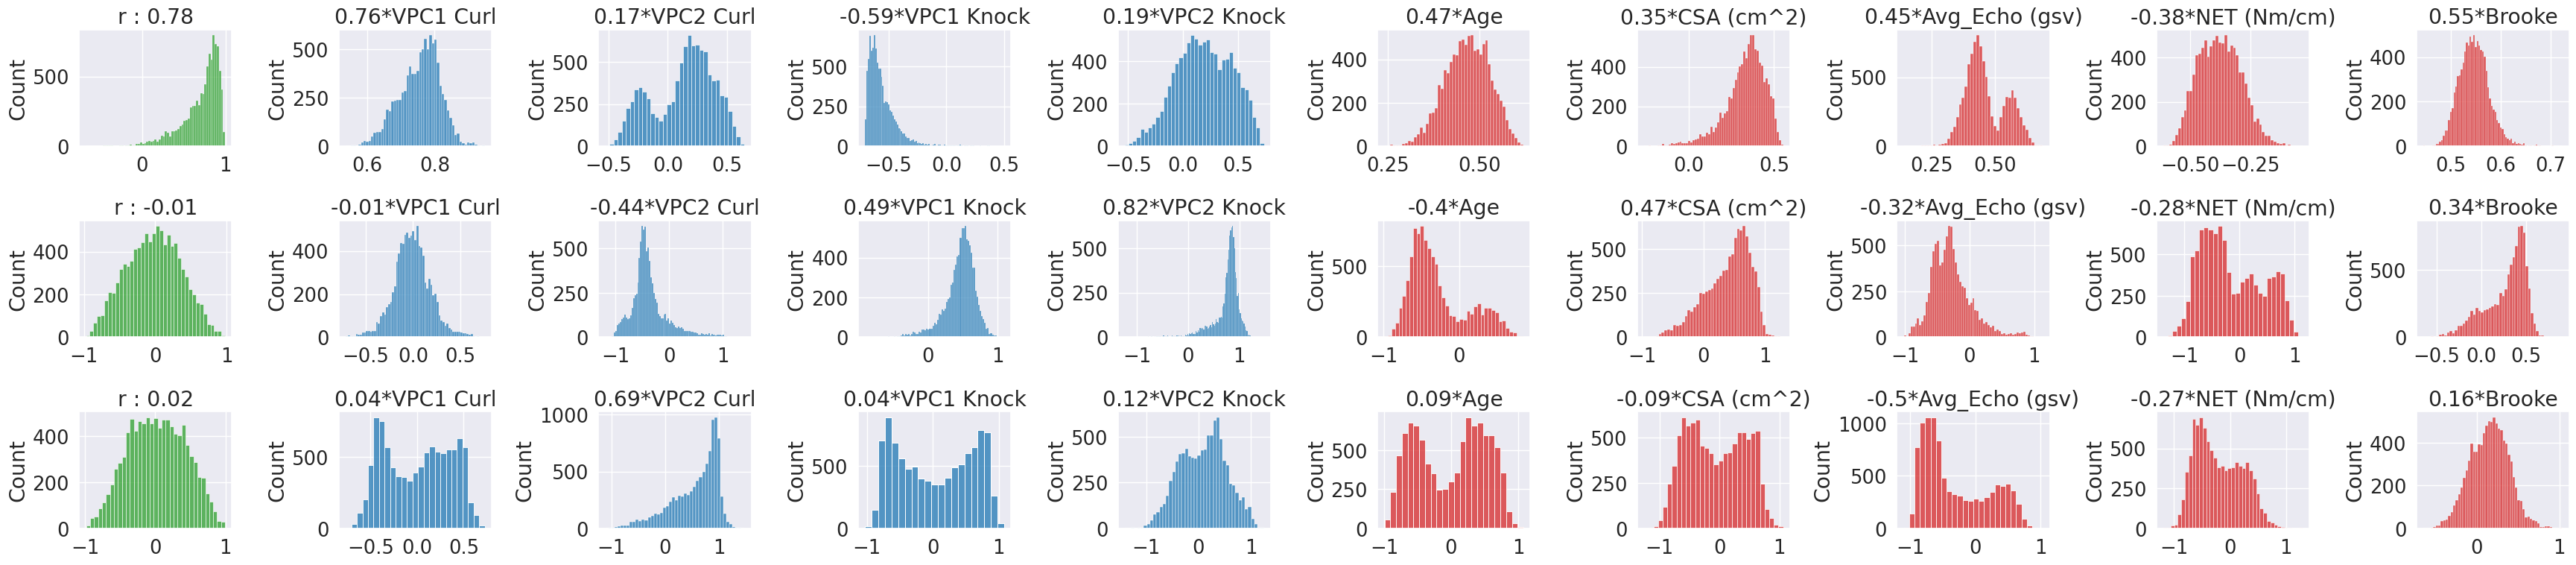

In [13]:
import seaborn as sns
sns.set(font_scale=1.7)
fig, axs = plt.subplots(3, 10, figsize=(35, 8))

for i, cca_r in cca_df.groupby('rank'):
    df = (cca_r.drop('rank', axis=1))
    
    for j, c in enumerate(df.columns):
        if c in cca_df.columns[2:6]:
            col = 'tab:blue'
            axs[i,j].set_title('{}*{}'.format(round(df[c].median(), 2), c))
        elif c in cca_df.columns[6:]:
            col = 'tab:red'
            axs[i,j].set_title('{}*{}'.format(round(df[c].median(), 2), c))
        else:
            col = 'tab:green'
            axs[i,j].set_title('{} : {}'.format(c, round( df[c].median(), 2)))
        hist = sns.histplot(data=df, x=c, ax=axs[i,j], color=col)
        hist.set(xlabel=None)
        #axs[i,j].axis('off')
        
        
plt.tight_layout()
#plt.savefig('./pics/cca_final.png', bbox_inches='tight')

for i, cca_r in cca_df.groupby('rank'):
    df = cca_r['r']
    #t_stat, p_value_overall = stats.ttest_1samp(df.values, 0)
    print(np.percentile(df, [5, 50, 95]))

# Fixing Sign

In [9]:
import numpy as np

# Reference index
ref = 0

# Reference weights
X_ref_weights = pls_list[0].x_weights_
Y_ref_weights = pls_list[0].y_weights_

for trial in range(1, len(pls_list)):  # Assuming pls_list is a list of PLSCanonical objects
    for dim in range(pls_list[0].x_weights_.shape[1]):
        # Correlation for X weights
        corr_x = np.dot(pls_list[trial].x_weights_[:, dim], X_ref_weights[:, dim])
        
        # Correlation for Y weights
        corr_y = np.dot(pls_list[trial].y_weights_[:, dim], Y_ref_weights[:, dim])
        
        if corr_x < 0:
            pls_list[trial].x_weights_[:, dim] = -pls_list[trial].x_weights_[:, dim]
            pls_list[trial].x_loadings_[:, dim] = -pls_list[trial].x_loadings_[:, dim]
            corrs[trial, dim] = -corrs[trial,dim]

        if corr_y < 0:
            pls_list[trial].y_weights_[:, dim] = -pls_list[trial].y_weights_[:, dim]
            pls_list[trial].y_loadings_[:, dim] = -pls_list[trial].y_loadings_[:, dim]
            corrs[trial, dim] = -corrs[trial,dim]


In [10]:
rho_df = pd.DataFrame(corrs.flatten(), columns=['rho'])
rho_df['rank'] = list(range(rank))*trials

X_weights = []
Y_weights = []

for i, plsca in enumerate(pls_list):
    for r in range(rank):

        r1 = list(plsca.x_loadings_[:,r])
        r1.append(r)
        
        r2 = list(plsca.y_loadings_[:,r])
        r2.append(r)

        X_weights.append(r1)
        Y_weights.append(r2)
        
xweights_df = pd.DataFrame(X_weights)
yweights_df = pd.DataFrame(Y_weights)

xweights_df.columns = [*X_cols,'rank']
yweights_df.columns = [*Y_cols,'rank']

cca_df = pd.concat([rho_df, xweights_df.drop('rank',axis=1), yweights_df.drop('rank',axis=1)],axis=1)
cca_df.groupby('rank').agg('median')

cca_df.columns = ['r','rank','VPC1 Curl', 'VPC2 Curl','VPC1 Knock','VPC2 Knock','Age',
                  'CSA (cm^2)', 'Avg_Echo (gsv)','NET (Nm/cm)', 'Brooke']

# cca_df.columns = ['r','rank','VPC1 Curl', 'VPC2 Curl','VPC3 Curl','VPC1 Knock','VPC2 Knock','VPC3 Knock','Age',
#                   'CSA (cm^2)', 'Avg_Echo (gsv)','NET (Nm/cm)', 'Brooke']

[0.24795 0.778   0.946  ]
[-0.653   -0.011    0.60505]
[-0.624  0.017  0.684]


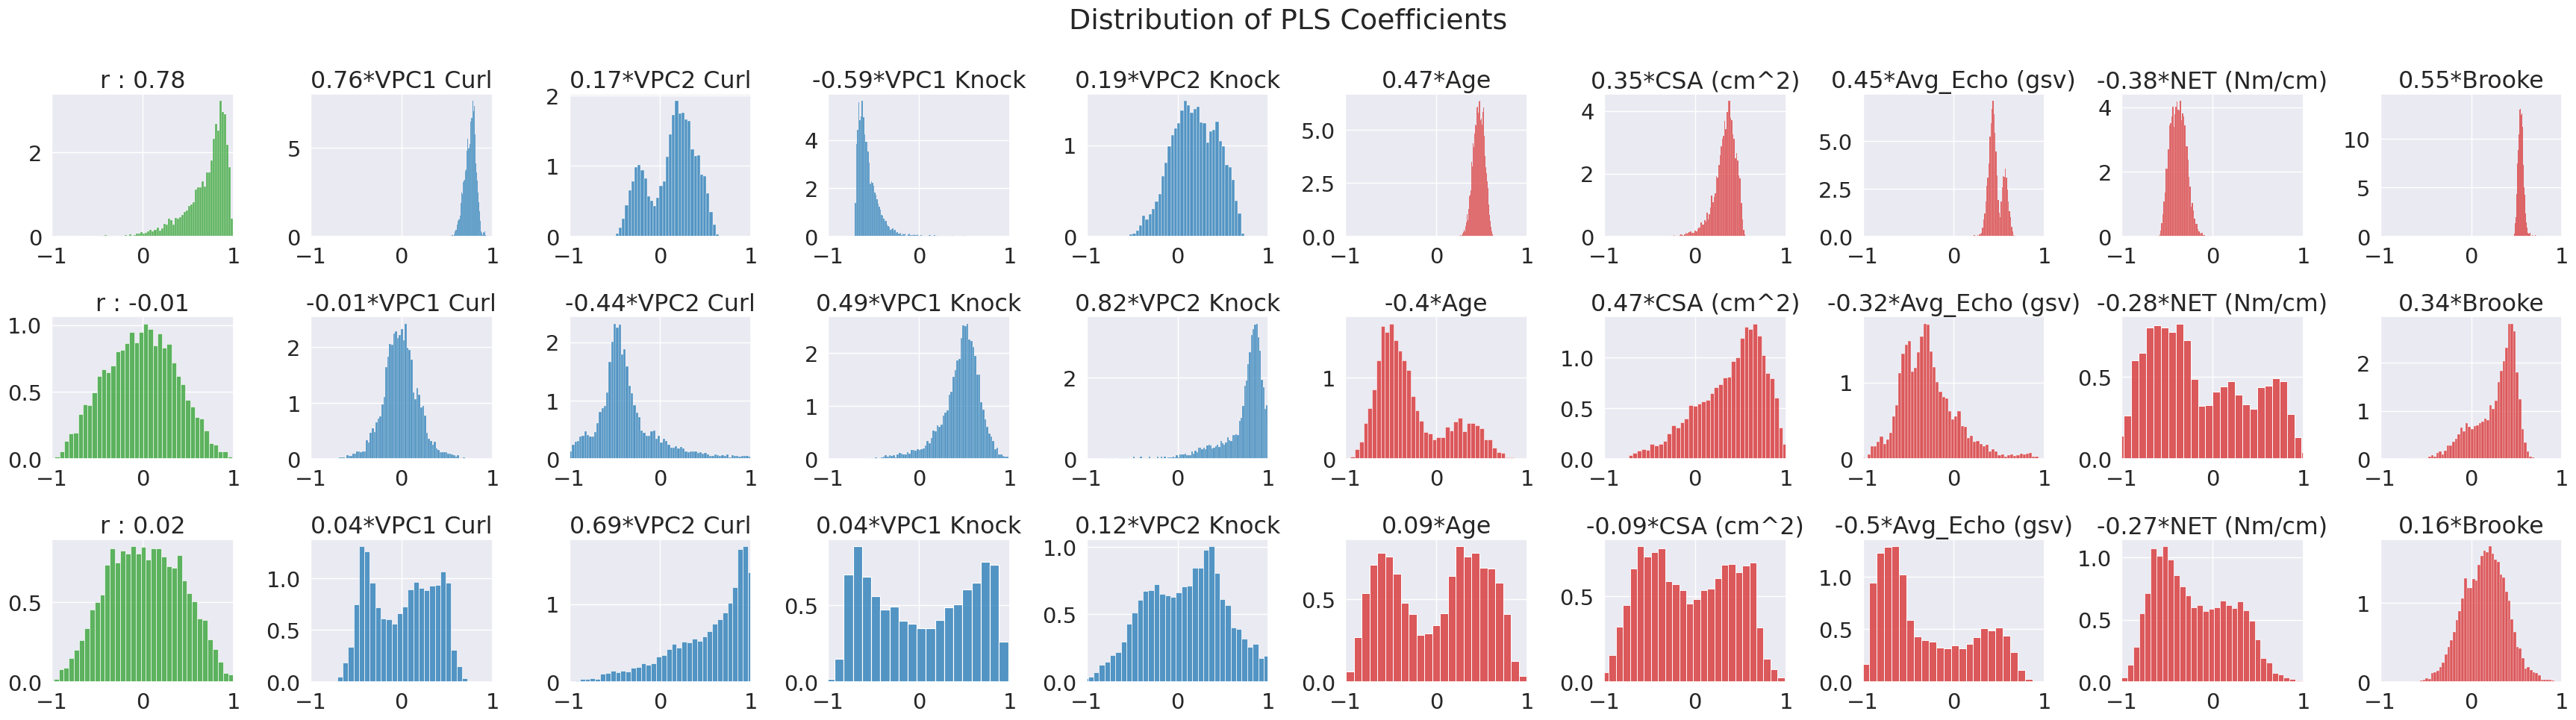

In [14]:
import seaborn as sns
sns.set(font_scale=1.9)
# Update the global font size
# plt.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(3, 10, figsize=(35, 10))

for i, cca_r in cca_df.groupby('rank'):
    df = (cca_r.drop('rank', axis=1))
    
    for j, c in enumerate(df.columns):
        axs[i,j].set_xlim([-1, 1])
        if c in cca_df.columns[2:6]:
            col = 'tab:blue'
            axs[i,j].set_title('{}*{}'.format(round(df[c].median(), 2), c))
        elif c in cca_df.columns[6:]:
            col = 'tab:red'
            axs[i,j].set_title('{}*{}'.format(round(df[c].median(), 2), c))
        else:
            col = 'tab:green'
            axs[i,j].set_title('{} : {}'.format(c, round( df[c].median(), 2)))
        hist = sns.histplot(data=df, x=c, ax=axs[i,j], color=col, stat='density')
        hist.set(xlabel=None,ylabel=None)
        #axs[i,j].axis('off')
        
        
plt.suptitle('Distribution of PLS Coefficients')
plt.tight_layout()
plt.savefig('./pics/cca_final.png', bbox_inches='tight')

for i, cca_r in cca_df.groupby('rank'):
    df = cca_r['r']
    #t_stat, p_value_overall = stats.ttest_1samp(df.values, 0)
    print(np.percentile(df, [5, 50, 95]))

In [12]:
# FPCA_without alignment
# [-0.3    0.359  0.813]
# [-0.603  0.182  0.85 ]
# [-0.67605  0.006    0.694  ]

# FPCA with alignment
# [0.336 0.772 0.939]
# [-0.66  -0.036  0.656]
# [-0.723 -0.061  0.705]

# NMF
# [0.01495 0.63    0.94   ]
# [-0.46905  0.279    0.812  ]
# [-0.593  0.143  0.771]